### Assessment of personality of worm based on early behavior 
# Step 1: Load data

In [50]:
import personality as prs
import load_data as ld
import helpers as hp
import nan_imputation as ni
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

In [51]:
# Load data
repo_root = hp.find_repo_root()
optogenetics_path = os.path.join(repo_root, 'Data', 'Optogenetics')
opto_data = ld.load_optogenetics(optogenetics_path)

# Step 2: Preprocessing

### NaN removal

In [52]:
# Rows to check for missing values (2:4 in zero-based indexing)
rows_to_check = slice(2, 4)  # Rows 2 and 3 not row 4

# Apply cut_array to each worm in the dataset
cut_nan_dict = {name: ni.cut_array(array, rows_to_check) for name, array in opto_data.items()}

In [53]:
# Print the data after NaN removal
# for name, item in cut_nan_dict.items():
#     worm_data = cut_nan_dict[name]
#     df = pd.DataFrame(worm_data.T, columns=['Frame', 'Speed', 'X', 'Y', 'Changed Pixels', 'Light_Pulse' ,'Category'])
    
#     # Check for NaN values in the DataFrame
#     if df.isna().sum().sum() == 0:
#         print(f"Worm {name} has no NaN values after NaN imputation.")
#     else:
#         print(f"Worm {name} still contains NaN values.")

# Step 3: Clustering

### Feature matrix

In [54]:
# `cut_nan_dict` is a dictionary of preprocessed worm data
worm_dataframes = []

# Iterate over each worm in cut_nan_dict
for worm_name, worm_array in cut_nan_dict.items():
    # Convert the NumPy array to a pandas DataFrame
    worm_df = pd.DataFrame(
        worm_array.T,  # Transpose the array (features as columns)
        columns=['Frame', 'Speed', 'X', 'Y', 'Changed Pixels', 'Light_Pulse', 'Category']  # Add column names
    )
    worm_dataframes.append(worm_df)

# Check if conversion worked
print(f"Converted {len(worm_dataframes)} worms into DataFrames.")

# Use create_feature_matrix to generate features
feature_matrix = prs.create_feature_matrix(worm_dataframes, percentile=50)

# Display the feature matrix
print("Feature Matrix:")
print(feature_matrix.head())

# # Save the feature matrix to a CSV file for inspection
# output_path = os.path.join(repo_root, 'Data', 'Plots', 'personality', 'feature_matrix.csv')
# feature_matrix.to_csv(output_path, index=False)
# print(f"Feature Matrix saved to: {output_path}")


Converted 42 worms into DataFrames.
Feature Matrix:
  worm_name  average_speed  variance_speed  threshold  movement_frequency  \
0    Worm 1       4.368967     1138.798265   1.066618           50.000000   
1    Worm 2       1.623409      363.418113   0.749258           49.999349   
2    Worm 3       2.886690      256.786384   1.011278           50.000000   
3    Worm 4       2.356340      123.662434   1.136713           49.999637   
4    Worm 5       2.050638       38.852848   1.098204           49.999625   

   active_time_ratio  total_distance  area_explored  
0           0.500000   209348.417733  297341.655305  
1           0.499993    88413.638818  348324.705543  
2           0.500000   355714.494935  268988.276081  
3           0.499996   276649.186244  183695.000864  
4           0.499996   142184.069605  210705.781073  


### Hierarchical clustering to find the number of clusters

Dendrogram saved to: c:\Users\msgar\OneDrive\Documents\EPFL\Cours\MA1\Machine_Learning\ML_project2\ML-Project-2\Data\Plots\personality\hierarchical_dendrogram.png


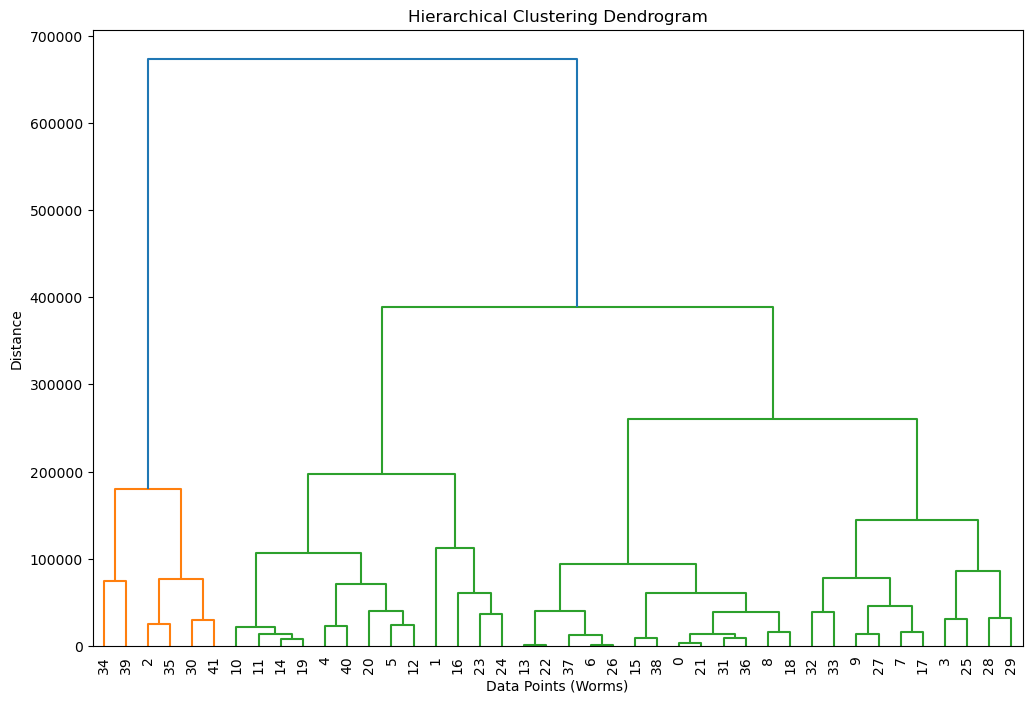

In [55]:
# Prepare input for clustering -> drop non-numeric columns like 'worm_name' or any other metadata
feature_matrix_copy = feature_matrix.copy()
clustering_input = feature_matrix_copy.drop(columns=['worm_name'])

# Define the output path for the dendrogram
dendrogram_path = os.path.join(repo_root, 'Data', 'Plots', 'personality', 'hierarchical_dendrogram.png')

# Ensure the directory exists
os.makedirs(os.path.dirname(dendrogram_path), exist_ok=True)

# Perform hierarchical clustering and save the dendrogram
prs.perform_hierarchical_clustering(
    feature_matrix=clustering_input,  # Pass only numeric data
    method='ward',
    output_file=dendrogram_path
)

print(f"Dendrogram saved to: {dendrogram_path}")

In [56]:
# Define the number of clusters
num_clusters = 2

# Define the personality map for 2 clusters (can be adjusted based on interpretations)
personality_map = {
    0: 'Cluster 0',  # Adjust labels after analyzing clustering results
    1: 'Cluster 1'
}

# Perform K-Means clustering
clustered_feature_matrix = prs.perform_kmeans_clustering(
    feature_matrix=clustering_input.copy(), 
    num_clusters=num_clusters, 
    personality_map=personality_map
)

# Preserve worm names for reference
worm_names = feature_matrix['worm_name']
# Reattach worm names to the clustered feature matrix
clustered_feature_matrix['worm_name'] = worm_names.values

# Display the updated feature matrix with clusters and personality labels
# print("Clustered Feature Matrix:")
# print(clustered_feature_matrix[['worm_name', 'Cluster', 'Personality']])

# personality_map = {
#     0: "Custer 0",
#     1: "Custer 1",
#     2: "Custer 2",
#     3: "Custer 3"
# }

# # Perform K-Means clustering
# num_clusters = 4  # Based on the dendrogram analysis
# clustered_feature_matrix = prs.perform_kmeans_clustering(
#     feature_matrix=clustering_input,
#     num_clusters=num_clusters,
#     personality_map=personality_map
# )

# # Preserve worm names for reference
# worm_names = feature_matrix['worm_name']
# # Reattach worm names to the clustered feature matrix
# clustered_feature_matrix['worm_name'] = worm_names.values


# # Display the updated feature matrix with clusters
# print("Clustered Feature Matrix:")
# print(clustered_feature_matrix[['worm_name', 'Cluster', 'Personality']])

c:\Users\msgar\miniconda3\envs\env_ML\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### PCA plot

PCA plot saved to: c:\Users\msgar\OneDrive\Documents\EPFL\Cours\MA1\Machine_Learning\ML_project2\ML-Project-2\Data\Plots\personality\pca_clusters.png


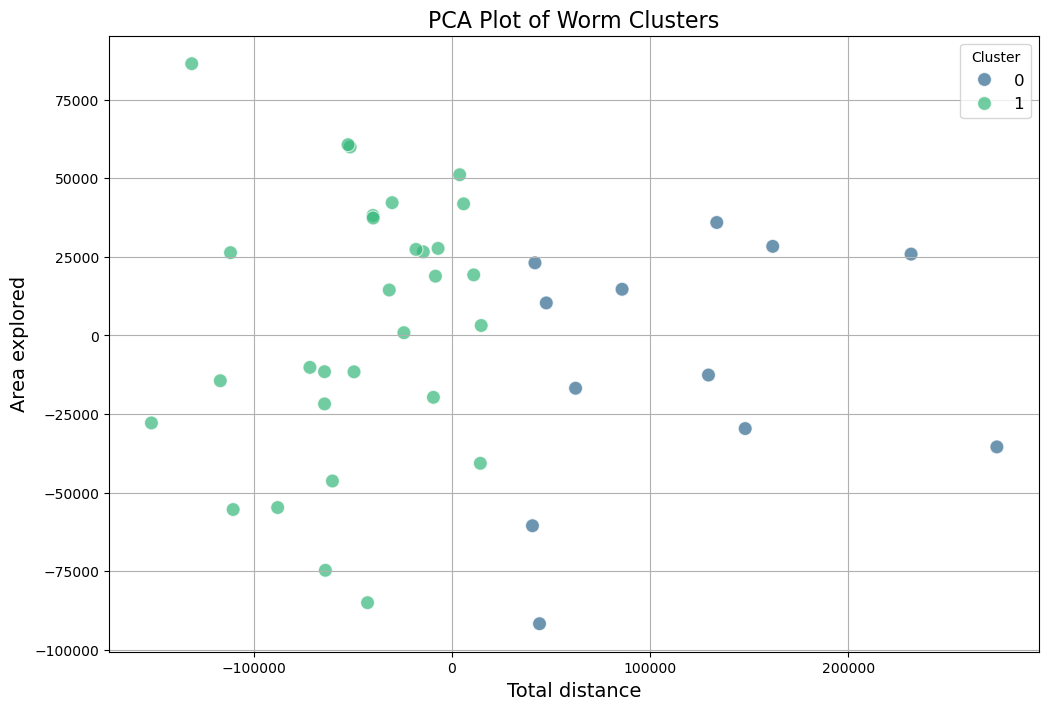

In [57]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data for PCA
clustered_feature_matrix_PCA = clustered_feature_matrix.copy()
numeric_features = clustered_feature_matrix_PCA.drop(columns=['worm_name', 'Cluster', 'Personality'])  # Drop non-numeric columns
cluster_labels = clustered_feature_matrix_PCA['Cluster']  # Save the cluster labels

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(numeric_features)

# Add PCA results to the clustered feature matrix
clustered_feature_matrix_PCA['PCA1'] = pca_result[:, 0]
clustered_feature_matrix_PCA['PCA2'] = pca_result[:, 1]

# Plot the PCA results
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PCA1',
    y='PCA2',
    hue='Cluster',  # Color by cluster
    data=clustered_feature_matrix_PCA,
    palette='viridis',
    s=100,
    alpha=0.7
)
plt.title('PCA Plot of Worm Clusters', fontsize=16)
plt.xlabel('Total distance', fontsize=14)
plt.ylabel('Area explored', fontsize=14)
plt.legend(title='Cluster', fontsize=12)
plt.grid(True)

# Save the PCA plot
pca_plot_path = os.path.join(repo_root, 'Data', 'Plots', 'personality', 'pca_clusters.png')
plt.savefig(pca_plot_path)
print(f"PCA plot saved to: {pca_plot_path}")

# Show the plot
plt.show()


In [58]:
# Get the PCA loadings (weights of each feature for each component)
pca_loadings = pd.DataFrame(
    pca.components_,
    columns=numeric_features.columns,
    index=['PCA1', 'PCA2']
)

print("PCA Loadings:")
print(pca_loadings)

PCA Loadings:
      average_speed  variance_speed     threshold  movement_frequency  \
PCA1   7.030044e-06        0.001751  5.798522e-07        4.307705e-10   
PCA2  -4.451725e-07        0.000280  3.037353e-07        7.879214e-10   

      active_time_ratio  total_distance  area_explored  
PCA1       4.307705e-12        0.997205       0.074699  
PCA2       7.879214e-12       -0.074700       0.997206  


From this, PCA1 (x-axis) is more influenced by total distance (0.997205),
and PCA2 (y-axis) is more influenced by area explored (0.997206)

# Step 4: Classification

### Random Forest Classification

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Prepare the feature matrix and labels
clustered_feature_matrix_rf = clustered_feature_matrix.copy()
X = clustered_feature_matrix_rf.drop(columns=['worm_name', 'Cluster', 'Personality'])  # Features
y = clustered_feature_matrix_rf['Cluster']  # Labels (or use 'Personality' for labeled data)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # Use 100 trees
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importances)

# Optional: Save the feature importances to a CSV
importance_output_path = os.path.join(repo_root, 'Data', 'Plots', 'personality', 'feature_importances.csv')
feature_importances.to_csv(importance_output_path, index=False)
print(f"Feature importances saved to: {importance_output_path}")

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.86      1.00      0.92         6

    accuracy                           0.89         9
   macro avg       0.93      0.83      0.86         9
weighted avg       0.90      0.89      0.88         9

Accuracy: 0.89

Feature Importance:
              Feature  Importance
5      total_distance    0.506993
0       average_speed    0.196590
1      variance_speed    0.088847
2           threshold    0.081802
6       area_explored    0.066128
3  movement_frequency    0.032447
4   active_time_ratio    0.027193
Feature importances saved to: c:\Users\msgar\OneDrive\Documents\EPFL\Cours\MA1\Machine_Learning\ML_project2\ML-Project-2\Data\Plots\personality\feature_importances.csv


### Logistic regression and Cross validation

10-Fold Cross-Validation Scores: [1.   1.   1.   1.   1.   1.   1.   1.   1.   0.75]
Mean Accuracy: 0.9750
Standard Deviation: 0.0750

Test Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

Test Set Accuracy: 1.0000

Feature Importance (Logistic Regression):
              Feature  Coefficient
3  movement_frequency     0.000479
1      variance_speed     0.000115
4   active_time_ratio     0.000005
0       average_speed    -0.000019
6       area_explored    -0.000256
2           threshold    -0.000537
5      total_distance    -0.001695
Feature importance plot saved to: c:\Users\msgar\OneDrive\Documents\EPFL\Cours\MA1\Machine_Learning\ML_project2\ML-Project-2\Data\Plots\personality\logistic_

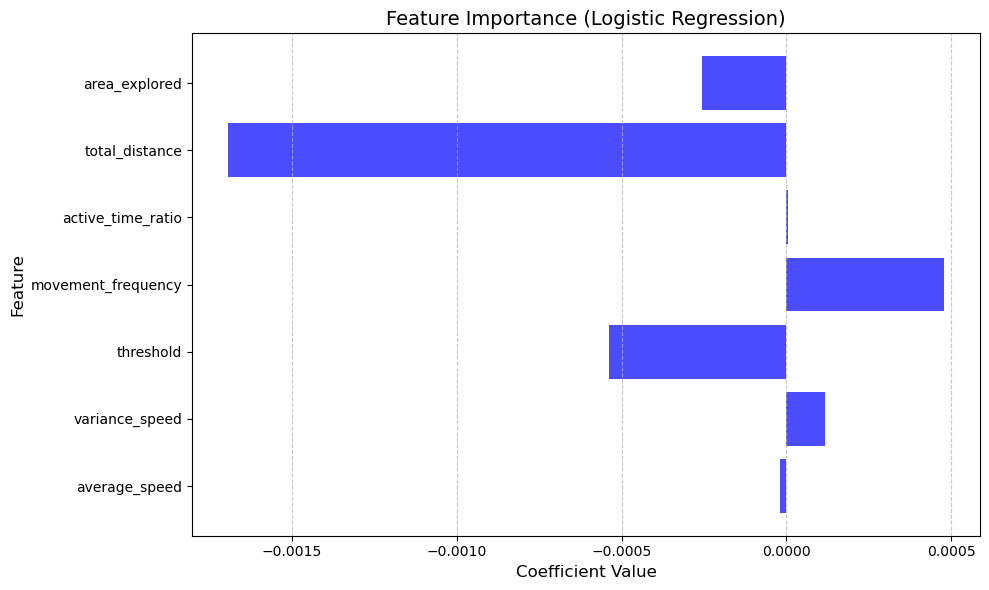

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Instantiate the Logistic Regression model
logistic_model = LogisticRegression(random_state=42, max_iter=1000)

# Perform 10-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(logistic_model, X, y, cv=skf, scoring='accuracy')

# Print cross-validation results
print(f"10-Fold Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_scores):.4f}")

# Train-Test Split for separate evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logistic_model.fit(X_train, y_train)

# Predict on the test set
y_test_pred = logistic_model.predict(X_test)

# Evaluate the model on the test set
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))
print(f"Test Set Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

# Analyze feature importance (coefficients) for Logistic Regression
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logistic_model.coef_[0]
})
print("\nFeature Importance (Logistic Regression):")
print(feature_importance.sort_values(by='Coefficient', ascending=False))

# Visualize feature importance
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='blue', alpha=0.7)
plt.title("Feature Importance (Logistic Regression)", fontsize=14)
plt.xlabel("Coefficient Value", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the feature importance plot
feature_importance_plot_path = os.path.join(repo_root, 'Data', 'Plots', 'personality', 'logistic_regression_feature_importance.png')
plt.savefig(feature_importance_plot_path)
print(f"Feature importance plot saved to: {feature_importance_plot_path}")

plt.show()

Random forest is not adaptated as the dataset is very small, so we only keep logistic regression.